In [26]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
import os
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
import os
import random

In [44]:
# Set paths
base_dir = 'Dataset_preprocessed'
train_dir = os.path.join(base_dir, 'Training_set')
test_dir = os.path.join(base_dir, 'Test_set')
classes = ['Abnormal', 'Normal']

# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 32

Class Distribution:
          Abnormal  Normal
Training       820     820
Test           115     207


<Figure size 800x500 with 0 Axes>

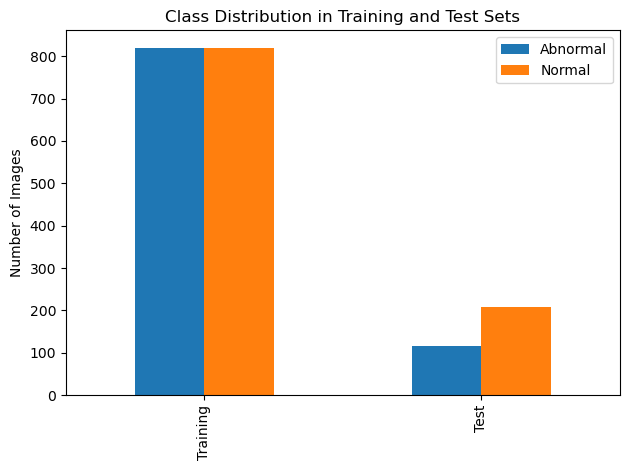

In [22]:
# 1. Class Distribution
def get_class_distribution(directory, set_name):
    counts = {}
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        counts[cls] = len([f for f in os.listdir(cls_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    return pd.DataFrame(counts, index=[set_name])

# Get distributions
train_dist = get_class_distribution(train_dir, 'Training')
test_dist = get_class_distribution(test_dir, 'Test')
dist_df = pd.concat([train_dist, test_dist])
print("Class Distribution:")
print(dist_df)

# Plot class distribution
plt.figure(figsize=(8, 5))
dist_df.plot(kind='bar', stacked=False)
plt.title('Class Distribution in Training and Test Sets')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

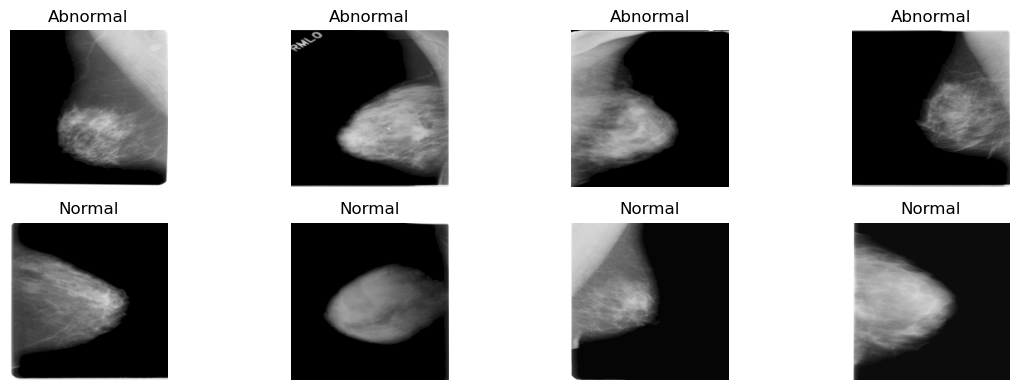

In [23]:
# 4. Sample Images
def display_sample_images(directory, num_samples=4):
    plt.figure(figsize=(12, 4))
    for i, cls in enumerate(classes):
        cls_dir = os.path.join(directory, cls)
        img_files = [f for f in os.listdir(cls_dir)][:num_samples]
        for j, img_file in enumerate(img_files):
            img = cv2.imread(os.path.join(cls_dir, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f'{cls}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(train_dir)

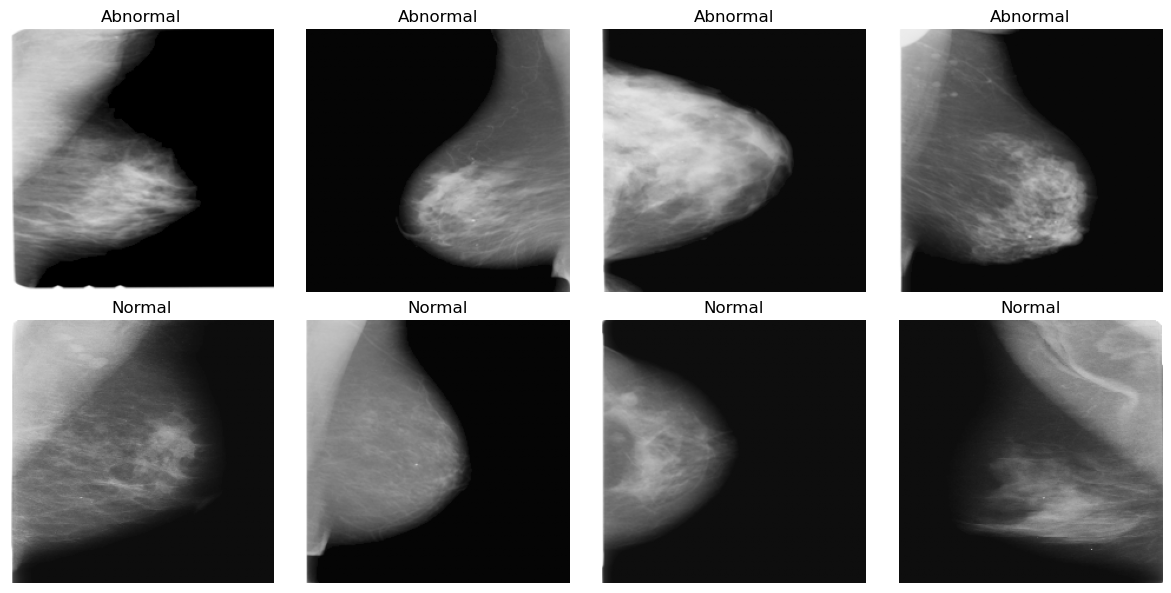

In [27]:
def display_sample_images(directory, num_samples=4):
    plt.figure(figsize=(num_samples * 3, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        cls_dir = os.path.join(directory, cls)
        img_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png'))]
        selected_files = random.sample(img_files, min(num_samples, len(img_files)))  # random sampling
        
        for j, img_file in enumerate(selected_files):
            img_path = os.path.join(cls_dir, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax = plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img/ 255.)
            plt.title(f'{cls}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call function
display_sample_images(train_dir)

Found 1640 images belonging to 2 classes.


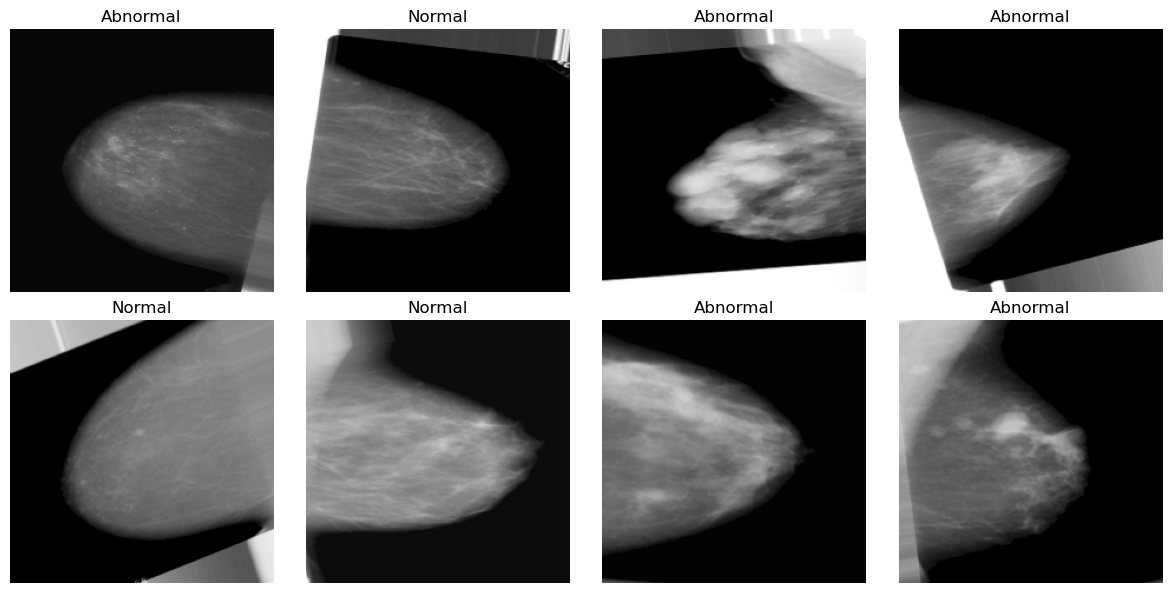

In [32]:
# Data Augmentation and Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(224, 224),
    shuffle=True
)

def plot_random_images_from_generator(generator, class_names=None, num_images=8):
    images, labels = next(generator)
    indices = random.sample(range(len(images)), min(num_images, len(images)))
    
    rows, cols = 2, 4
    plt.figure(figsize=(cols * 3, rows * 3))

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)

        # Convert to uint8 for better visualization
        img = (images[idx] * 255).astype(np.uint8)
        plt.imshow(img)

        # Convert label to class name
        if class_names is not None:
            if labels.ndim > 1:
                label_index = np.argmax(labels[idx])
            else:
                label_index = int(labels[idx])
            title = class_names[label_index]
        else:
            title = f"Class {labels[idx]}"
        
        plt.title(title)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Display sample augmented images
plot_random_images_from_generator(train_generator, class_names=classes, num_images=8)

Found 1640 images belonging to 2 classes.


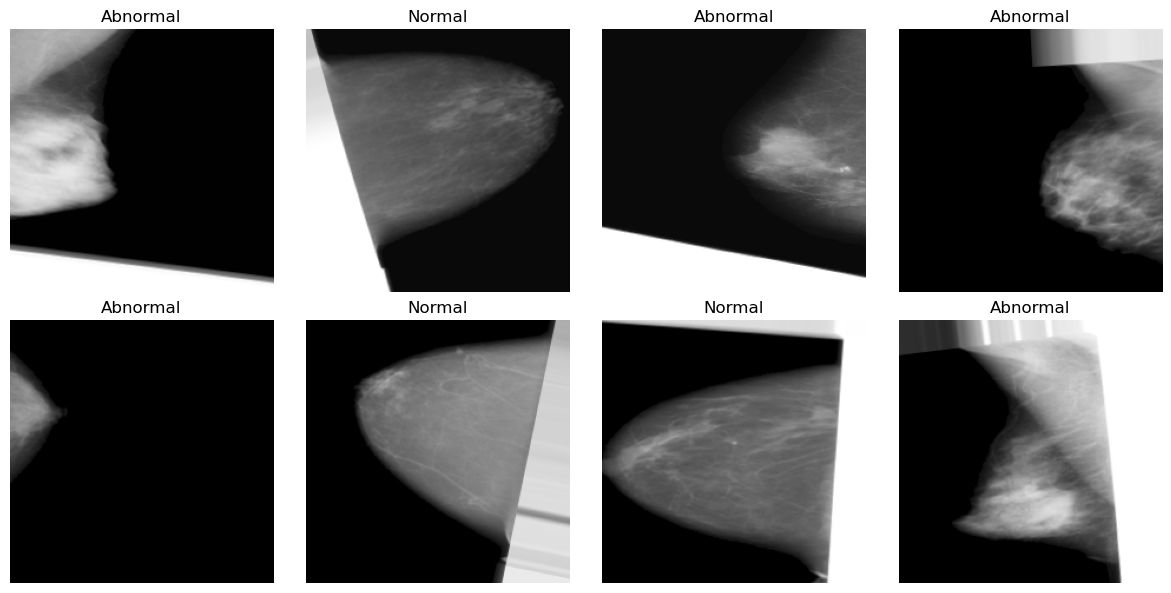

In [42]:

# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., 
                                rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

def plot_random_images_from_generator(generator, class_names=None, num_images=8):
    # Fetch one batch
    images, labels = next(generator)
    indices = random.sample(range(len(images)), min(num_images, len(images)))
    
    rows = 2
    cols = 4
    plt.figure(figsize=(cols * 3, rows * 3))
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[idx])
        
        # Decode label
        if class_names is not None:
            if labels.ndim > 1:
                label_index = np.argmax(labels[idx])
            else:
                label_index = int(labels[idx])
            title = class_names[label_index]
        else:
            title = f"Class {labels[idx]}"
        
        plt.title(title)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Usage example:
plot_random_images_from_generator(train_generator, class_names=classes, num_images=8)

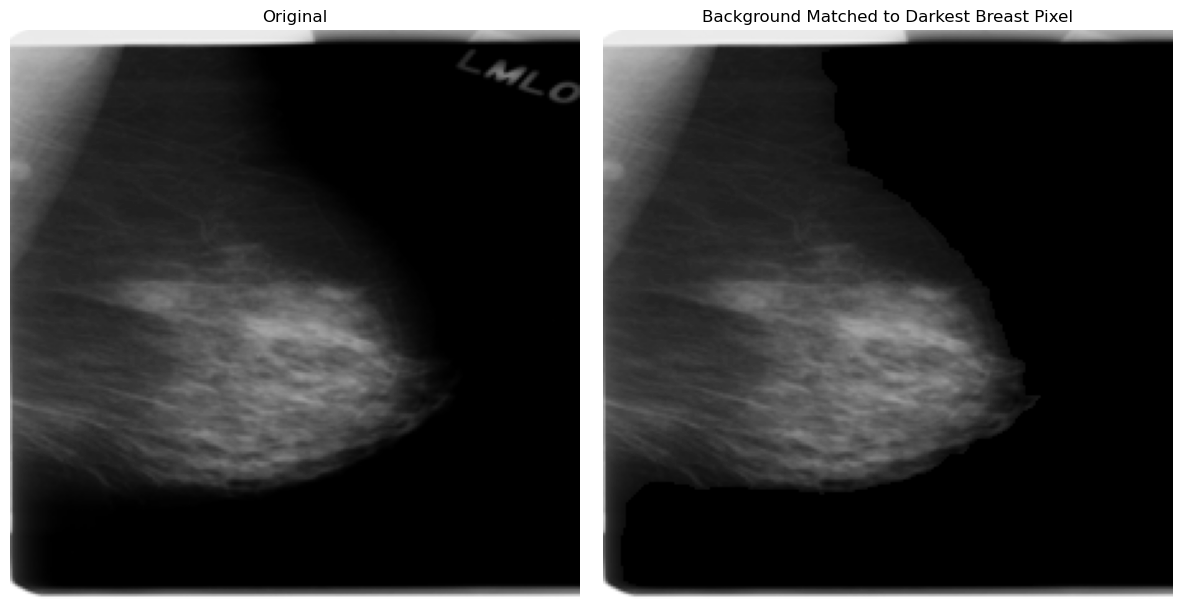

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image in grayscale
img = cv2.imread(r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\Dataset\Training_set\Abnormal\Abnormal (2).png', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not loaded. Check the file path.")

# Blur to reduce noise
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Threshold to separate breast from background
_, thresh = cv2.threshold(blurred, 15, 255, cv2.THRESH_BINARY)

# Find contours and keep the largest one (the breast)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Create mask from the largest contour
mask = np.zeros_like(img)
cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=-1)

# Optional: Close small holes in the mask
kernel = np.ones((5,5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Extract the breast region
breast_only = cv2.bitwise_and(img, img, mask=mask)

# ▶️ Find minimum grayscale value in the breast region (excluding 0s)
non_zero_pixels = breast_only[mask > 0]
min_val = int(np.min(non_zero_pixels)) if len(non_zero_pixels) > 0 else 0

# Fill background (mask == 0) with this minimum value
cleaned = breast_only.copy()
cleaned[mask == 0] = min_val

# Show results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Background Matched to Darkest Breast Pixel")
plt.imshow(cleaned/255., cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# import os
# import cv2
# import numpy as np
# from tqdm import tqdm

# # Set your input and output directories
# train_dir = r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\Dataset\Test_set'
# output_dir = r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\Dataset_preprocessed\Test_set'

# # Make sure output directory exists
# os.makedirs(output_dir, exist_ok=True)

# # Loop through each class folder (e.g., 'Normal', 'Abnormal')
# for class_name in os.listdir(train_dir):
#     class_path = os.path.join(train_dir, class_name)
#     if not os.path.isdir(class_path):
#         continue

#     # Create corresponding folder in output directory
#     output_class_path = os.path.join(output_dir, class_name)
#     os.makedirs(output_class_path, exist_ok=True)

#     # Process each image in the class folder
#     for filename in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
#         input_path = os.path.join(class_path, filename)
#         output_path = os.path.join(output_class_path, filename)

#         # Read image in grayscale
#         img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
#         if img is None:
#             print(f"Warning: Couldn't read image {input_path}")
#             continue

#         try:
#             # Apply Gaussian blur
#             blurred = cv2.GaussianBlur(img, (5, 5), 0)

#             # Threshold to separate foreground
#             _, thresh = cv2.threshold(blurred, 15, 255, cv2.THRESH_BINARY)

#             # Find contours and keep the largest
#             contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             if not contours:
#                 print(f"No contours found in {input_path}")
#                 continue
#             largest_contour = max(contours, key=cv2.contourArea)

#             # Create mask from largest contour
#             mask = np.zeros_like(img)
#             cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=-1)

#             # Clean mask with morphological closing
#             kernel = np.ones((5, 5), np.uint8)
#             mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#             # Apply mask to get breast region
#             breast_only = cv2.bitwise_and(img, img, mask=mask)

#             # Fill background with minimum pixel in breast area
#             non_zero_pixels = breast_only[mask > 0]
#             min_val = int(np.min(non_zero_pixels)) if len(non_zero_pixels) > 0 else 0
#             cleaned = breast_only.copy()
#             cleaned[mask == 0] = min_val

#             # Save cleaned image
#             cv2.imwrite(output_path, cleaned)

#         except Exception as e:
#             print(f"Error processing {input_path}: {e}")


Processing Normal: 100%|██████████| 207/207 [00:05<00:00, 40.40it/s]


In [ ]:
# from PIL import Image
# import os

# input_folder = r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\Dataset\Training_set\Abnormal'
# output_folder = r'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\Dataset\Training_set\Abnormal'

# os.makedirs(output_folder, exist_ok=True)

# for filename in os.listdir(input_folder):
#     if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#         img_path = os.path.join(input_folder, filename)
#         img = Image.open(img_path)
#         resized_img = img.resize((224, 224))
        
#         save_path = os.path.join(output_folder, filename)
#         resized_img.save(save_path)

# print("All images resized.")
